# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

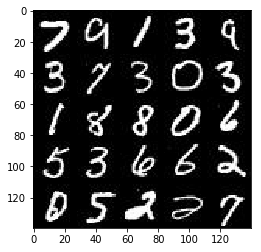

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

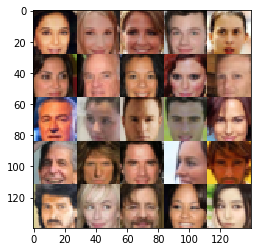

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return real_input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = lrelu(x, alpha)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        
        x = tf.reshape(x, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(x, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7 * 7 * 256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, padding='same')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    discriminator_real_output, discriminator_real_logits = discriminator(input_real, alpha=alpha)
    discriminator_fake_output, discriminator_fake_logits = discriminator(generator_model, reuse=True, alpha=alpha)
    
    smooth = 0.1
    
    real_labels = tf.ones_like(discriminator_real_output) * (1 - smooth)
    fake_labels = tf.zeros_like(discriminator_real_output)
    generator_labels = tf.ones_like(discriminator_fake_output)
    
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits,
                                                                                    labels=real_labels))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits,
                                                                                    labels=fake_labels))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits,
                                                                           labels=generator_labels))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [v for v in trainable_vars if v.name.startswith('discriminator')]
    generator_vars = [v for v in trainable_vars if v.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    discriminator_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    generator_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(discriminator_updates):
        discriminator_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)

    with tf.control_dependencies(generator_updates):
        generator_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
            
    return discriminator_opt, generator_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_n=10, show_n=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discriminator_loss, generator_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(discriminator_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(generator_opt, feed_dict={input_z: batch_z})

                if steps % print_n == 0:
                    training_loss_discriminator = discriminator_loss.eval({input_z: batch_z, input_real: batch_images})
                    training_loss_generator = generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(training_loss_discriminator),
                          "Generator Loss: {:.4f}".format(training_loss_generator))

                if steps % show_n == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0206... Generator Loss: 0.2913
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.7509
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 2.4318
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.5078
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 2.0159
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 2.0431


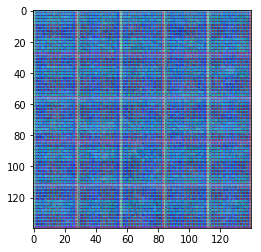

Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 2.3488
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 3.5246
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.7957
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 3.1252
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 2.3828
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 3.7969
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 3.4649
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 2.3023
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 4.9954
Epoch 1/1... Discriminator Loss: 0.3792... Generator Loss: 4.2181


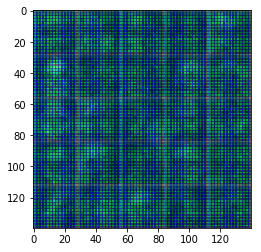

Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 4.8837
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 3.4686
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 3.2932
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 2.9329
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 2.3023
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 2.6961
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 3.4534
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 1.8721
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 5.2918
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 2.8671


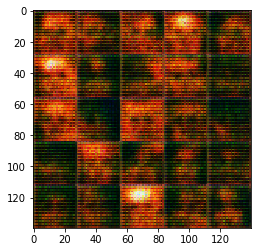

Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 2.8797
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.3543
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.2442
Epoch 1/1... Discriminator Loss: 0.4573... Generator Loss: 2.8227
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 3.1966
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 2.3951
Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 2.7068
Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 2.5541
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 2.7111
Epoch 1/1... Discriminator Loss: 2.3028... Generator Loss: 0.4049


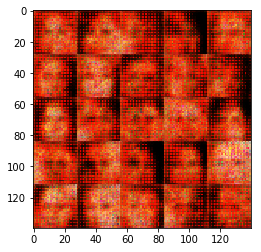

Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 3.0775
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 2.3122
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 3.0903
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 2.7825
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 2.2919
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 1.7737
Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 2.2794
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 5.5188
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.2508


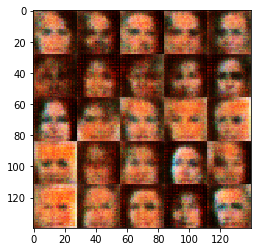

Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 3.5612
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 1.5905
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 1.8750
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 3.3333
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 2.6236
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.7634
Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 2.2905
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.2871


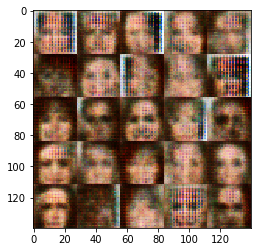

Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 2.5398
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 2.5294
Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 1.9141
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 3.0512
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 1.5624
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 3.1270
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 3.3965
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.7259
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.5321


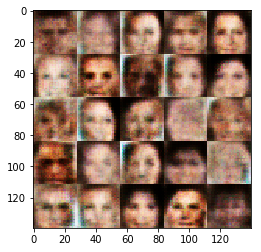

Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 2.0140
Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 2.6724
Epoch 1/1... Discriminator Loss: 0.6992... Generator Loss: 2.9725
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.7519
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.8935
Epoch 1/1... Discriminator Loss: 0.6023... Generator Loss: 2.5089
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 1.5233
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.3864


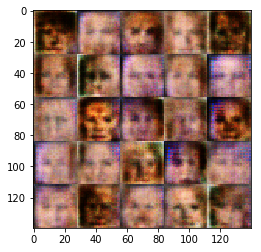

Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.9356
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 2.0638
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.9495
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7415


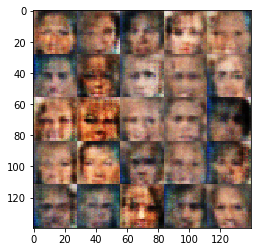

Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.4985
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.3751
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.3127
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.5732


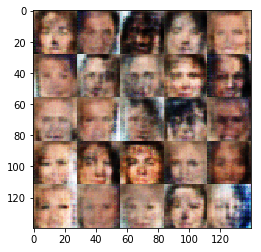

Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.3329
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 2.2961
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.7452
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.8829
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.8718


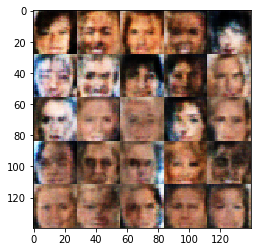

Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.9889
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.3452
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.0292


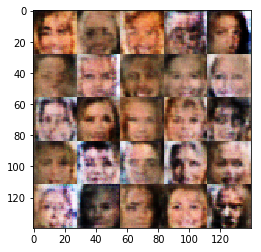

Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.8017
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.4554
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.0736


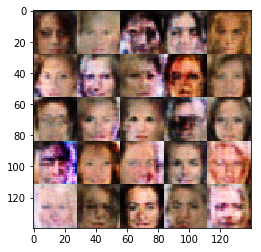

Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.0867


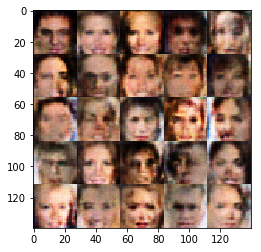

Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.4136
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.6084


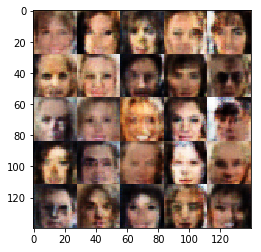

Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.3228
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.7052


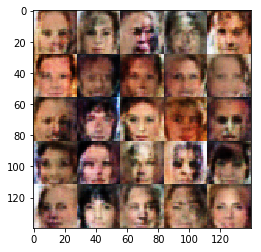

Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.5910
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.8496


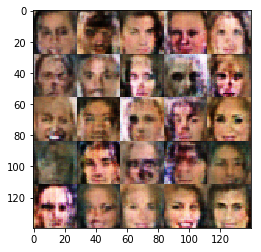

Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 1.5354


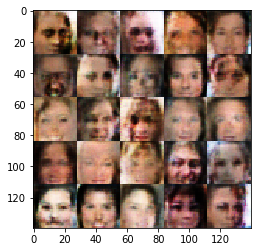

Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 0.8483... Generator Loss: 1.2633
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.9654


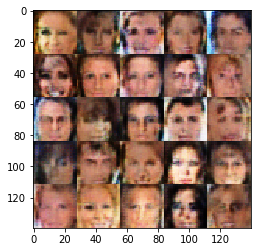

Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.2308


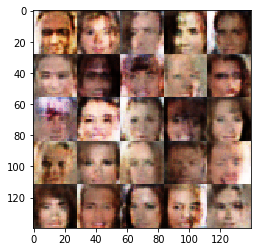

Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.5967
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.1701


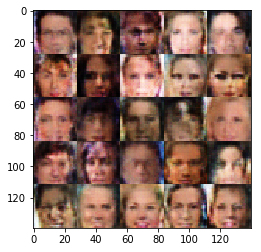

Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.9079


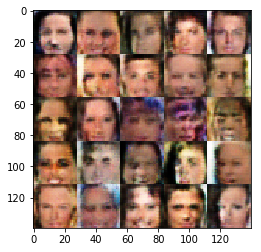

Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.1998
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 1.5718


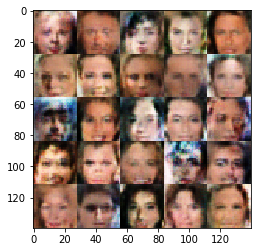

Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.8856


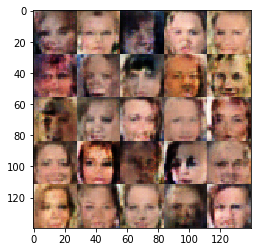

Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.1436


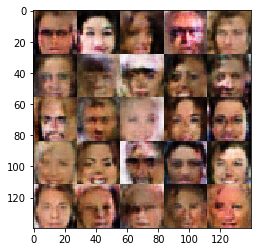

Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.2897
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.0360


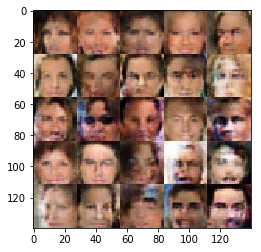

Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 1.9035


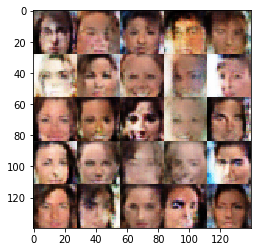

Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.3205
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.7928
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 1.6285
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.1793


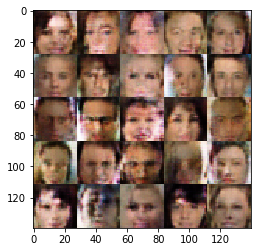

Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.5164
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.5733


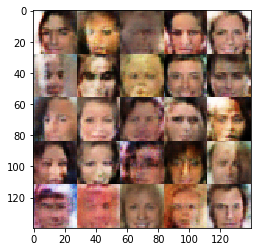

Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.5065
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.8973


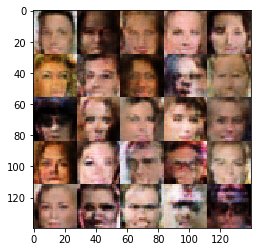

Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.5943


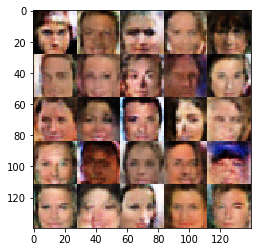

Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.1879
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.3224


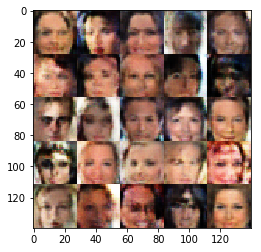

Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.4544
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.6766


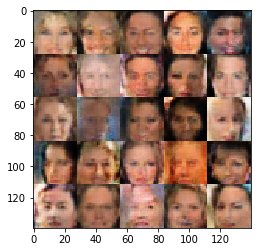

Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.4064
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.7293
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.6966


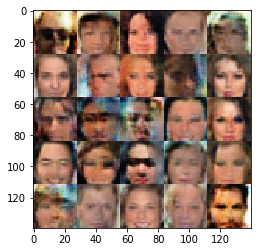

Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.4512


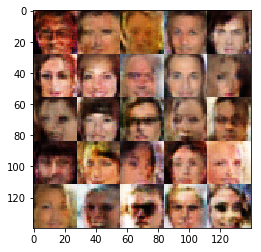

Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 1.6378


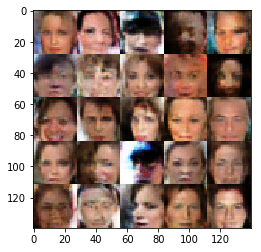

Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.9915


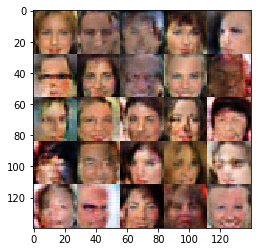

Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.6441
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8919


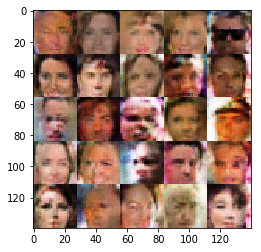

Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.6099


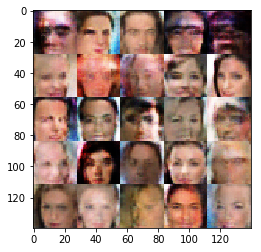

Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.0699


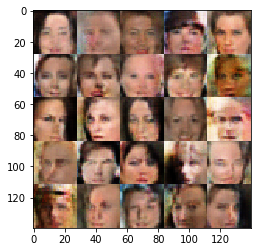

Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.4216
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.3491


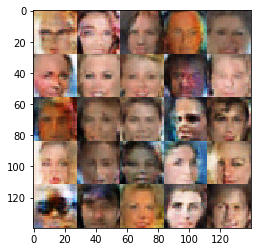

Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.3433
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.2212


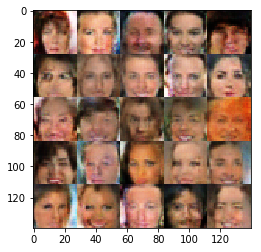

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.6897
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.3203
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.1408


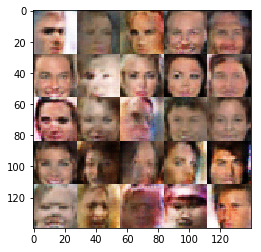

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.9123


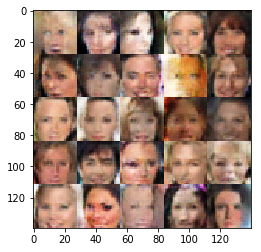

Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.3829
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6645


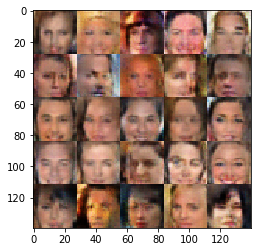

Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 1.6318
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.3302
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 0.9135


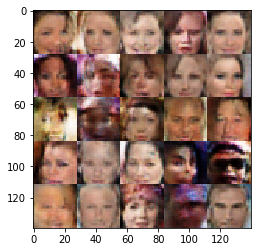

Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 1.6617
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 1.5316
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 2.4386


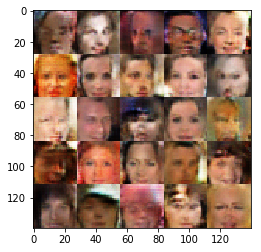

Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.4981
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.2896
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 3.4040
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.6739... Generator Loss: 0.3709


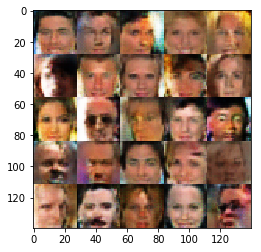

Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 0.4392... Generator Loss: 2.9685
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.4097
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.3617
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 0.9265


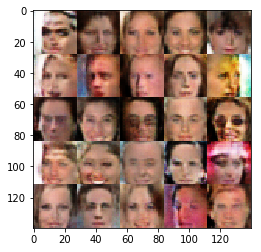

Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.6288
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 3.8061
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 2.3552
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.8148
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.8606


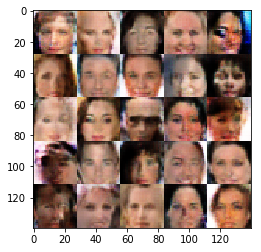

Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 3.8828
Epoch 1/1... Discriminator Loss: 2.4308... Generator Loss: 0.1775
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 2.8956


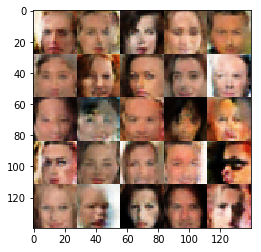

Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 1.9523... Generator Loss: 0.2998
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.3572
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 2.1819
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 3.0575
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.8942


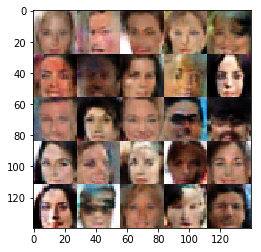

Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.8115
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.6019
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.2786
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 2.1448
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 1.7973
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 2.7565
Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.4349


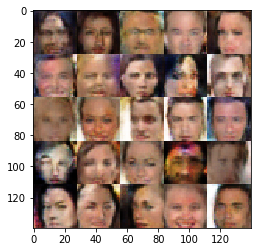

Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.8317
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 3.4371
Epoch 1/1... Discriminator Loss: 1.6948... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.5916
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.4748
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.7971


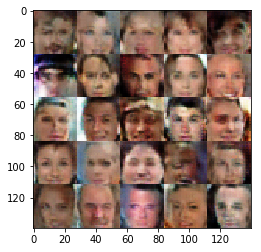

Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 1.5227
Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 2.1701
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.0471


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.